<a href="https://colab.research.google.com/github/overthemoonlala/movie/blob/main/%EC%98%81%ED%99%94_%EA%B4%80%EA%B0%9D%EC%88%98_%EC%98%88%EC%B8%A1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!sudo apt-get install -y fonts-nanum
!sudo fc-cache -fv
!rm ~/.cache/matplotlib -rf

Reading package lists... Done
Building dependency tree       
Reading state information... Done
fonts-nanum is already the newest version (20180306-3).
0 upgraded, 0 newly installed, 0 to remove and 34 not upgraded.
/usr/share/fonts: caching, new cache contents: 0 fonts, 1 dirs
/usr/share/fonts/truetype: caching, new cache contents: 0 fonts, 3 dirs
/usr/share/fonts/truetype/humor-sans: caching, new cache contents: 1 fonts, 0 dirs
/usr/share/fonts/truetype/liberation: caching, new cache contents: 16 fonts, 0 dirs
/usr/share/fonts/truetype/nanum: caching, new cache contents: 10 fonts, 0 dirs
/usr/local/share/fonts: caching, new cache contents: 0 fonts, 0 dirs
/root/.local/share/fonts: skipping, no such directory
/root/.fonts: skipping, no such directory
/usr/share/fonts/truetype: skipping, looped directory detected
/usr/share/fonts/truetype/humor-sans: skipping, looped directory detected
/usr/share/fonts/truetype/liberation: skipping, looped directory detected
/usr/share/fonts/truetype/n

# 영화관객수 예측

In [ ]:
import numpy as np
import pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt
from matplotlib import gridspec
import matplotlib.font_manager as fm
import seaborn as sns
import warnings
from scipy.special import boxcox1p, inv_boxcox1p


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


# EDA 
- title : 영화의 제목
- distributor : 배급사
- genre : 장르
- release_time : 개봉일
- time : 상영시간(분)
- screening_rat : 상영등급
- director : 감독이름
- dir_prev_bfnum : 해당 감독이 이 영화를 만들기 전 제작에 참여한 영화에서의 평균 관객수(단 관객수가 알려지지 않은 영화 제외)
- dir_prev_num : 해당 감독이 이 영화를 만들기 전 제작에 참여한 영화의 개수(단 관객수가 알려지지 않은 영화 제외)
- num_staff : 스텝수
- num_actor : 주연배우수
- box_off_num : 관객수


box_off_num : 예측피쳐

In [ ]:
df_train  = pd.read_csv('/content/drive/MyDrive/moviedata/movies_train.csv')
df_test  = pd.read_csv('/content/drive/MyDrive/moviedata/movies_test.csv')
submission = pd.read_csv('/content/drive/MyDrive/moviedata/submission.csv')

In [ ]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 600 entries, 0 to 599
Data columns (total 12 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   title           600 non-null    object 
 1   distributor     600 non-null    object 
 2   genre           600 non-null    object 
 3   release_time    600 non-null    object 
 4   time            600 non-null    int64  
 5   screening_rat   600 non-null    object 
 6   director        600 non-null    object 
 7   dir_prev_bfnum  270 non-null    float64
 8   dir_prev_num    600 non-null    int64  
 9   num_staff       600 non-null    int64  
 10  num_actor       600 non-null    int64  
 11  box_off_num     600 non-null    int64  
dtypes: float64(1), int64(5), object(6)
memory usage: 56.4+ KB


In [ ]:
df_test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 243 entries, 0 to 242
Data columns (total 11 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   title           243 non-null    object 
 1   distributor     243 non-null    object 
 2   genre           243 non-null    object 
 3   release_time    243 non-null    object 
 4   time            243 non-null    int64  
 5   screening_rat   243 non-null    object 
 6   director        243 non-null    object 
 7   dir_prev_bfnum  107 non-null    float64
 8   dir_prev_num    243 non-null    int64  
 9   num_staff       243 non-null    int64  
 10  num_actor       243 non-null    int64  
dtypes: float64(1), int64(4), object(6)
memory usage: 21.0+ KB


In [ ]:
df_train.head()

,title,distributor,genre,release_time,time,screening_rat,director,dir_prev_bfnum,dir_prev_num,num_staff,num_actor,box_off_num
0,개들의 전쟁,롯데엔터테인먼트,액션,2012-11-22,96,청소년 관람불가,조병옥,NaN,0,91,2,23398
1,내부자들,(주)쇼박스,느와르,2015-11-19,130,청소년 관람불가,우민호,1161602.50,2,387,3,7072501
2,은밀하게 위대하게,(주)쇼박스,액션,2013-06-05,123,15세 관람가,장철수,220775.25,4,343,4,6959083
3,나는 공무원이다,(주)NEW,코미디,2012-07-12,101,전체 관람가,구자홍,23894.00,2,20,6,217866
4,불량남녀,쇼박스(주)미디어플렉스,코미디,2010-11-04,108,15세 관람가,신근호,1.00,1,251,2,483387


In [ ]:
df_test.head()

,title,distributor,genre,release_time,time,screening_rat,director,dir_prev_bfnum,dir_prev_num,num_staff,num_actor
0,용서는 없다,시네마서비스,느와르,2010-01-07,125,청소년 관람불가,김형준,3.005290e+05,2,304,3
1,아빠가 여자를 좋아해,(주)쇼박스,멜로/로맨스,2010-01-14,113,12세 관람가,이광재,3.427002e+05,4,275,3
2,하모니,CJ 엔터테인먼트,드라마,2010-01-28,115,12세 관람가,강대규,4.206611e+06,3,419,7
3,의형제,(주)쇼박스,액션,2010-02-04,116,15세 관람가,장훈,6.913420e+05,2,408,2
4,평행 이론,CJ 엔터테인먼트,공포,2010-02-18,110,15세 관람가,권호영,3.173800e+04,1,380,1


In [ ]:
submission.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 243 entries, 0 to 242
Data columns (total 2 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   title        243 non-null    object
 1   box_off_num  243 non-null    int64 
dtypes: int64(1), object(1)
memory usage: 3.9+ KB


In [ ]:
submission.head()

,title,box_off_num
0,용서는 없다,0
1,아빠가 여자를 좋아해,0
2,하모니,0
3,의형제,0
4,평행 이론,0


In [ ]:
print(df_train.shape)
print(df_test.shape)
print(submission.shape)

(600, 12)
(243, 11)
(243, 2)


In [ ]:
#결측치 확인
df_train.isnull().sum() # dir_prev_bfnum : 해당 감독이 이 영화를 만들기 전 제작에 참여한 영화에서의 평균 관객수(단 관객수가 알려지지 않은 영화 제외)

title               0
distributor         0
genre               0
release_time        0
time                0
screening_rat       0
director            0
dir_prev_bfnum    330
dir_prev_num        0
num_staff           0
num_actor           0
box_off_num         0
dtype: int64

In [ ]:
df_test.isnull().sum()

title               0
distributor         0
genre               0
release_time        0
time                0
screening_rat       0
director            0
dir_prev_bfnum    136
dir_prev_num        0
num_staff           0
num_actor           0
dtype: int64

In [ ]:
df_train.describe().T

,count,mean,std,min,25%,50%,75%,max
time,600.0,1.008633e+02,1.809753e+01,45.0,89.00,100.000,114.000,180.0
dir_prev_bfnum,270.0,1.050443e+06,1.791408e+06,1.0,20380.00,478423.625,1286568.625,17615314.0
dir_prev_num,600.0,8.766667e-01,1.183409e+00,0.0,0.00,0.000,2.000,5.0
num_staff,600.0,1.511183e+02,1.656547e+02,0.0,17.00,82.500,264.000,869.0
num_actor,600.0,3.706667e+00,2.446889e+00,0.0,2.00,3.000,4.000,25.0
box_off_num,600.0,7.081818e+05,1.828006e+06,1.0,1297.25,12591.000,479886.750,14262766.0


In [ ]:
df_test.describe().T

,count,mean,std,min,25%,50%,75%,max
time,243.0,109.798354,1.240227e+02,40.0,91.0,104.0,1.145000e+02,2015.0
dir_prev_bfnum,107.0,891669.516044,1.217341e+06,34.0,62502.0,493120.0,1.080850e+06,6173099.5
dir_prev_num,243.0,0.851852,1.200321e+00,0.0,0.0,0.0,1.000000e+00,6.0
num_staff,243.0,159.316872,1.629766e+02,0.0,18.0,105.0,2.820000e+02,776.0
num_actor,243.0,3.477366,2.111192e+00,0.0,2.0,3.0,4.000000e+00,16.0


In [ ]:
# 장르별 관객수
genre_count = df_train[['genre', 'box_off_num']].groupby('genre').mean().sort_values('box_off_num')
genre_count

,box_off_num
genre,
뮤지컬,6.627000e+03
다큐멘터리,6.717226e+04
서스펜스,8.261100e+04
애니메이션,1.819267e+05
멜로/로맨스,4.259680e+05
미스터리,5.275482e+05
공포,5.908325e+05
드라마,6.256898e+05
코미디,1.193914e+06


In [ ]:
# 장르별 관객수 막대차트 그리기
genre_graph = df_train.groupby(['genre'], as_index = False)['box_off_num'].sum()
genre_graph

,genre,box_off_num
0,SF,23248494
1,공포,24814966
2,느와르,61119768
3,다큐멘터리,6247020
4,드라마,138277444
5,멜로/로맨스,33225507
6,뮤지컬,33135
7,미스터리,8968319
8,서스펜스,165222
9,애니메이션,3820460


<BarContainer object of 12 artists>

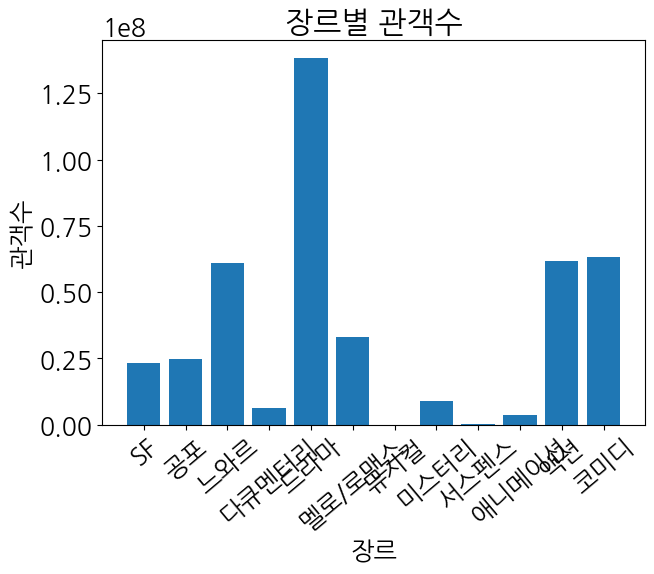

In [ ]:
!apt-get -qq install fonts-nanum


fe = fm.FontEntry(
    fname=r'/usr/share/fonts/truetype/nanum/NanumGothic.ttf', # ttf 파일이 저장되어 있는 경로
    name='NanumGothic')                        # 이 폰트의 원하는 이름 설정
fm.fontManager.ttflist.insert(0, fe)              # Matplotlib에 폰트 추가
plt.rcParams.update({'font.size': 18, 'font.family': 'NanumGothic'}) # 폰트 설정



# plt.rcParams['font.size'] = 20
plt.rcParams['figure.figsize'] = (7,5)
plt.title('장르별 관객수')
plt.xlabel('장르')
plt.ylabel('관객수')
plt.xticks(rotation= 40)
plt.bar(genre_graph['genre'], genre_graph['box_off_num'])

드라마/코미디/느와르/액션 순으로 관객 수가 높다

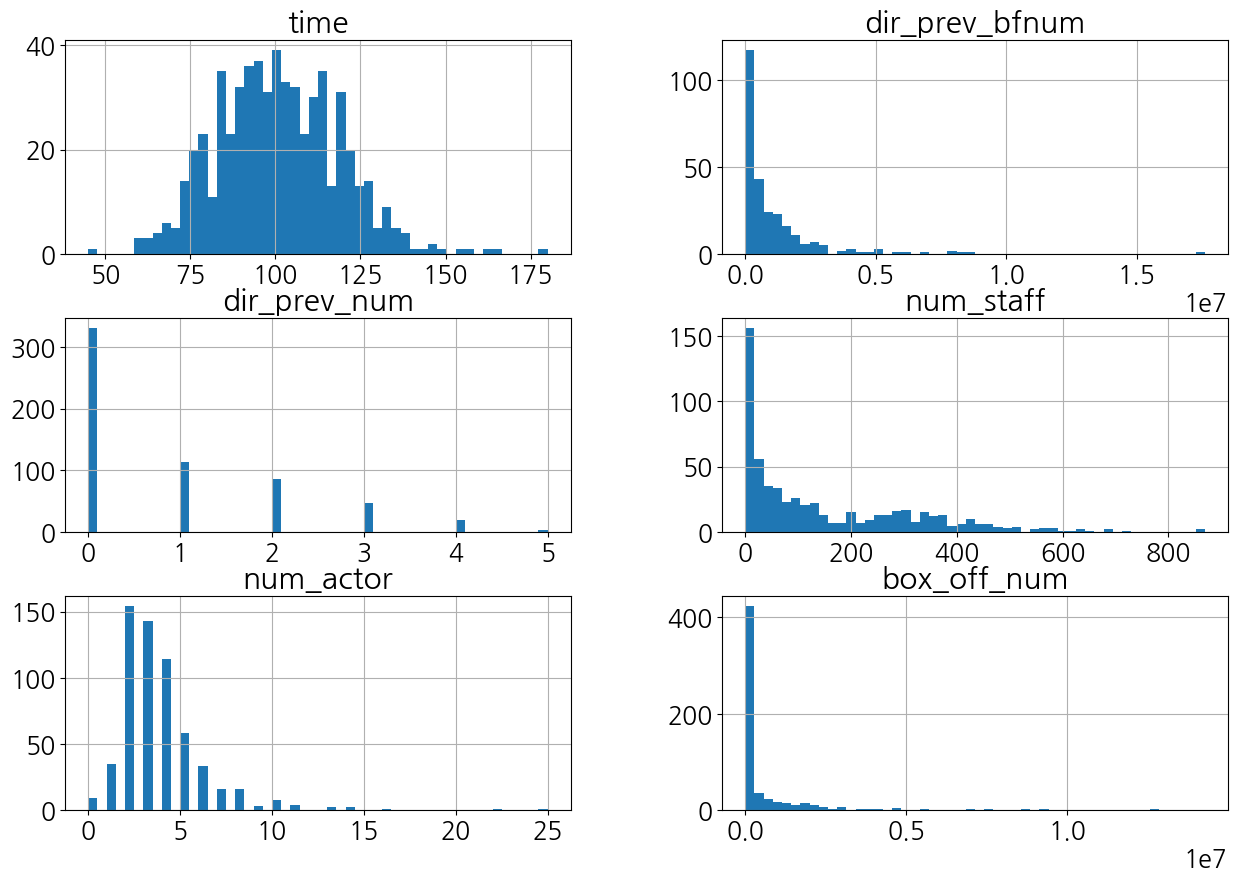

In [ ]:
# 히스토그램으로 변수 분포 확인
import matplotlib.pyplot as plt
%matplotlib inline

df_train.hist(bins = 50, figsize = (15,10))
plt.show()

# 상관분석

In [ ]:
heatmap_data = df_train[['time','dir_prev_num','num_staff','num_actor','box_off_num']]

In [ ]:
heatmap_data.corr()

,time,dir_prev_num,num_staff,num_actor,box_off_num
time,1.000000,0.306727,0.623205,0.114153,0.441452
dir_prev_num,0.306727,1.000000,0.450706,0.014006,0.259674
num_staff,0.623205,0.450706,1.000000,0.077871,0.544265
num_actor,0.114153,0.014006,0.077871,1.000000,0.111179
box_off_num,0.441452,0.259674,0.544265,0.111179,1.000000


<Axes: title={'center': 'Pearson Correalation of Features'}>

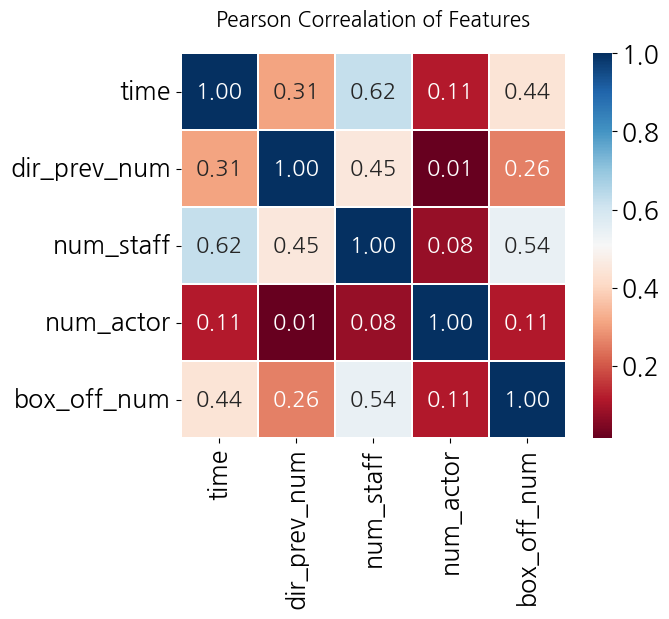

In [ ]:
colormap = plt.cm.RdBu
plt.figure(figsize=(7, 5))

plt.title('Pearson Correalation of Features', y=1.05, size=15)

sns.heatmap(heatmap_data.astype(float).corr(), linewidths=0.1, vmax=1.0
            , square=True, cmap=colormap, linecolor='white', annot=True, annot_kws={'size': 16}, fmt='.2f')

# num_staff와 num_actor에서 가장 강한 상관관계를 보인다.

In [ ]:
# 컬럼 삭제
df_train = df_train.drop('title', axis=1)
df_test = df_test.drop('title', axis=1)

# distributor
배급사

- 배급사는 169개가 있으므로, title과 달리 배급사와 영화는 일대다 관계
- 1. 과거 배급 영화 수가 배급사의 파워(순위)를 결정하는 요소일 수 있다.
- 2. 과거 많은 관객을 모은 배급사일수록 향후에도 많은 관객을 모을 것으로 기대할 수 있다.

In [ ]:
len(df_train['distributor'].unique())

169

In [ ]:
# 배급사별 영화 수 확인
# 1, 2위가 압도적이고 3-6위가 그 다음이다.
df_train_dist_cnt = pd.DataFrame(df_train['distributor'].value_counts())
df_train_dist_cnt.head(10)

,distributor
CJ 엔터테인먼트,54
롯데엔터테인먼트,52
(주)NEW,30
(주)마운틴픽쳐스,29
(주)쇼박스,26
인디스토리,26
골든타이드픽처스,15
(주) 케이알씨지,14
(주) 영화사조제,10
영화사 진진,10


In [ ]:
# 배급사별 관객 수 확인.
df_train_dist_sum = pd.DataFrame(df_train.groupby('distributor')['box_off_num'].sum().sort_values(ascending=False))
df_train_dist_sum.head(10)


,box_off_num
distributor,
CJ 엔터테인먼트,116788093
(주)쇼박스,88053064
(주)NEW,65532145
롯데엔터테인먼트,64383745
CJ E&M Pictures,8244674
NEW,8152133
CJ E&M 영화부문,7515928
CGV아트하우스,6590943
시네마서비스,5381059


In [ ]:
# 상위 5개 배급사 외에는 기타로 처리한다.

distributor_list = df_train_dist_cnt[:5].distributor

def distributor_agg(distributor):
    if distributor in distributor_list:
        return distributor
    else:
        return '기타'

df_train['distributor'] = df_train['distributor'].apply(lambda x : distributor_agg(x))
df_test['distributor'] = df_test['distributor'].apply(lambda x : distributor_agg(x))


# release_time


- 개봉일
- 영화 흥행에 개봉 일정이 어떤 영향을 미치는지 알아보기


In [ ]:
train_time = df_train[['release_time','box_off_num']].set_index('release_time').sort_index()
train_time

,box_off_num
release_time,
2010-01-02,353
2010-01-14,791
2010-01-14,143458
2010-01-14,27083
2010-01-14,155281
...,...
2015-12-17,1599
2015-12-24,329
2015-12-30,627586


<Axes: xlabel='release_time'>

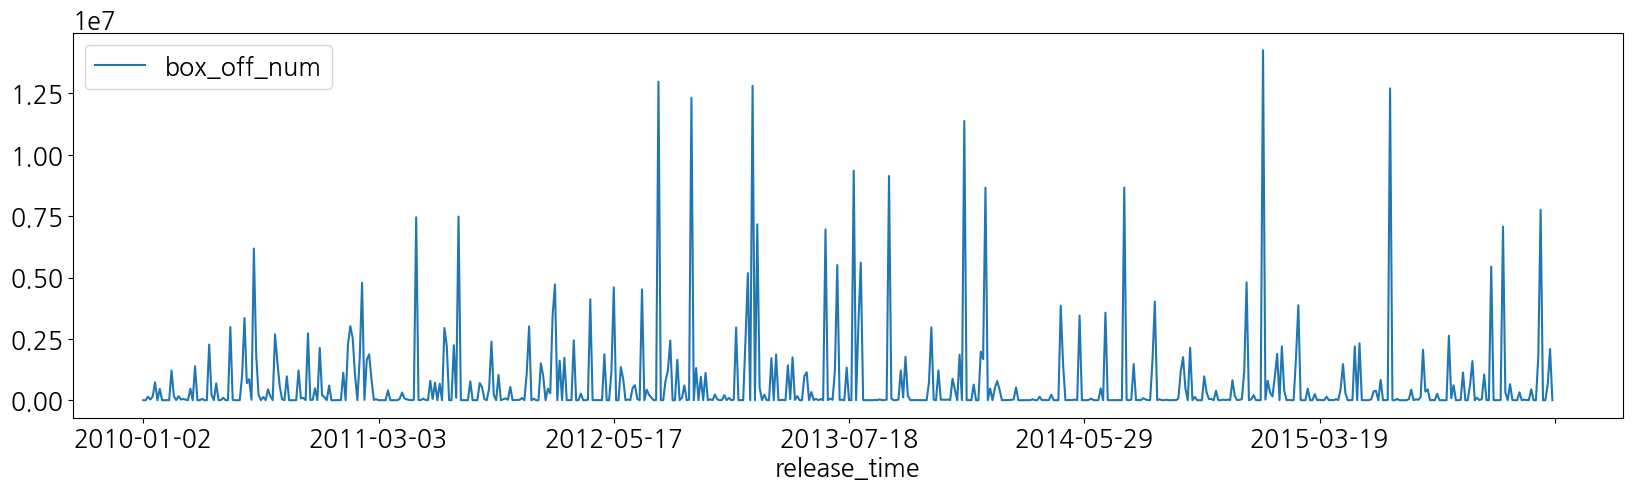

In [ ]:
train_time.plot(figsize=(20, 5))

In [ ]:
train_time['datetime'] = pd.to_datetime(train_time.index)
train_time['year'] = train_time['datetime'].dt.year
train_time['month'] = train_time['datetime'].dt.month
train_time['day'] = train_time['datetime'].dt.day_name()
train_time['yearmonth'] = train_time['datetime'].dt.to_period('M')
train_time


,box_off_num,datetime,year,month,day,yearmonth
release_time,,,,,,
2010-01-02,353,2010-01-02,2010,1,Saturday,2010-01
2010-01-14,791,2010-01-14,2010,1,Thursday,2010-01
2010-01-14,143458,2010-01-14,2010,1,Thursday,2010-01
2010-01-14,27083,2010-01-14,2010,1,Thursday,2010-01
2010-01-14,155281,2010-01-14,2010,1,Thursday,2010-01
...,...,...,...,...,...,...
2015-12-17,1599,2015-12-17,2015,12,Thursday,2015-12
2015-12-24,329,2015-12-24,2015,12,Thursday,2015-12
2015-12-30,627586,2015-12-30,2015,12,Wednesday,2015-12


In [ ]:
# 연도 테이블
df_year = train_time.groupby('year')[['box_off_num']].sum().reset_index()
df_year

,year,box_off_num
0,2010,48749235
1,2011,50309371
2,2012,83223817
3,2013,95698992
4,2014,75423331
5,2015,71504305


In [ ]:
# 월별 테이블
df_yearmonth = train_time.groupby(['yearmonth','year','month'])[['box_off_num']].sum().reset_index()
df_yearmonth

,yearmonth,year,month,box_off_num
0,2010-01,2010,1,1520657
1,2010-02,2010,2,10232
2,2010-03,2010,3,1548312
3,2010-04,2010,4,1964416
4,2010-05,2010,5,3357253
...,...,...,...,...
67,2015-08,2015,8,3054825
68,2015-09,2015,9,4028216
69,2015-10,2015,10,4564507
70,2015-11,2015,11,13513754


In [ ]:
df_yearmonth[df_yearmonth['year'] == 2010]

,yearmonth,year,month,box_off_num
0,2010-01,2010,1,1520657
1,2010-02,2010,2,10232
2,2010-03,2010,3,1548312
3,2010-04,2010,4,1964416
4,2010-05,2010,5,3357253
5,2010-06,2010,6,2998743
6,2010-07,2010,7,5933593
7,2010-08,2010,8,8352713
8,2010-09,2010,9,6434789
9,2010-10,2010,10,4112059


In [ ]:
# 요일별 테이블
df_day = train_time.groupby('day')[['box_off_num']].sum().reset_index()
df_day = df_day.reindex([1, 4, 5, 3, 0, 2], axis='index')
df_day

,day,box_off_num
1,Monday,1736
4,Tuesday,5183138
5,Wednesday,239433802
3,Thursday,180192720
0,Friday,97302
2,Saturday,353


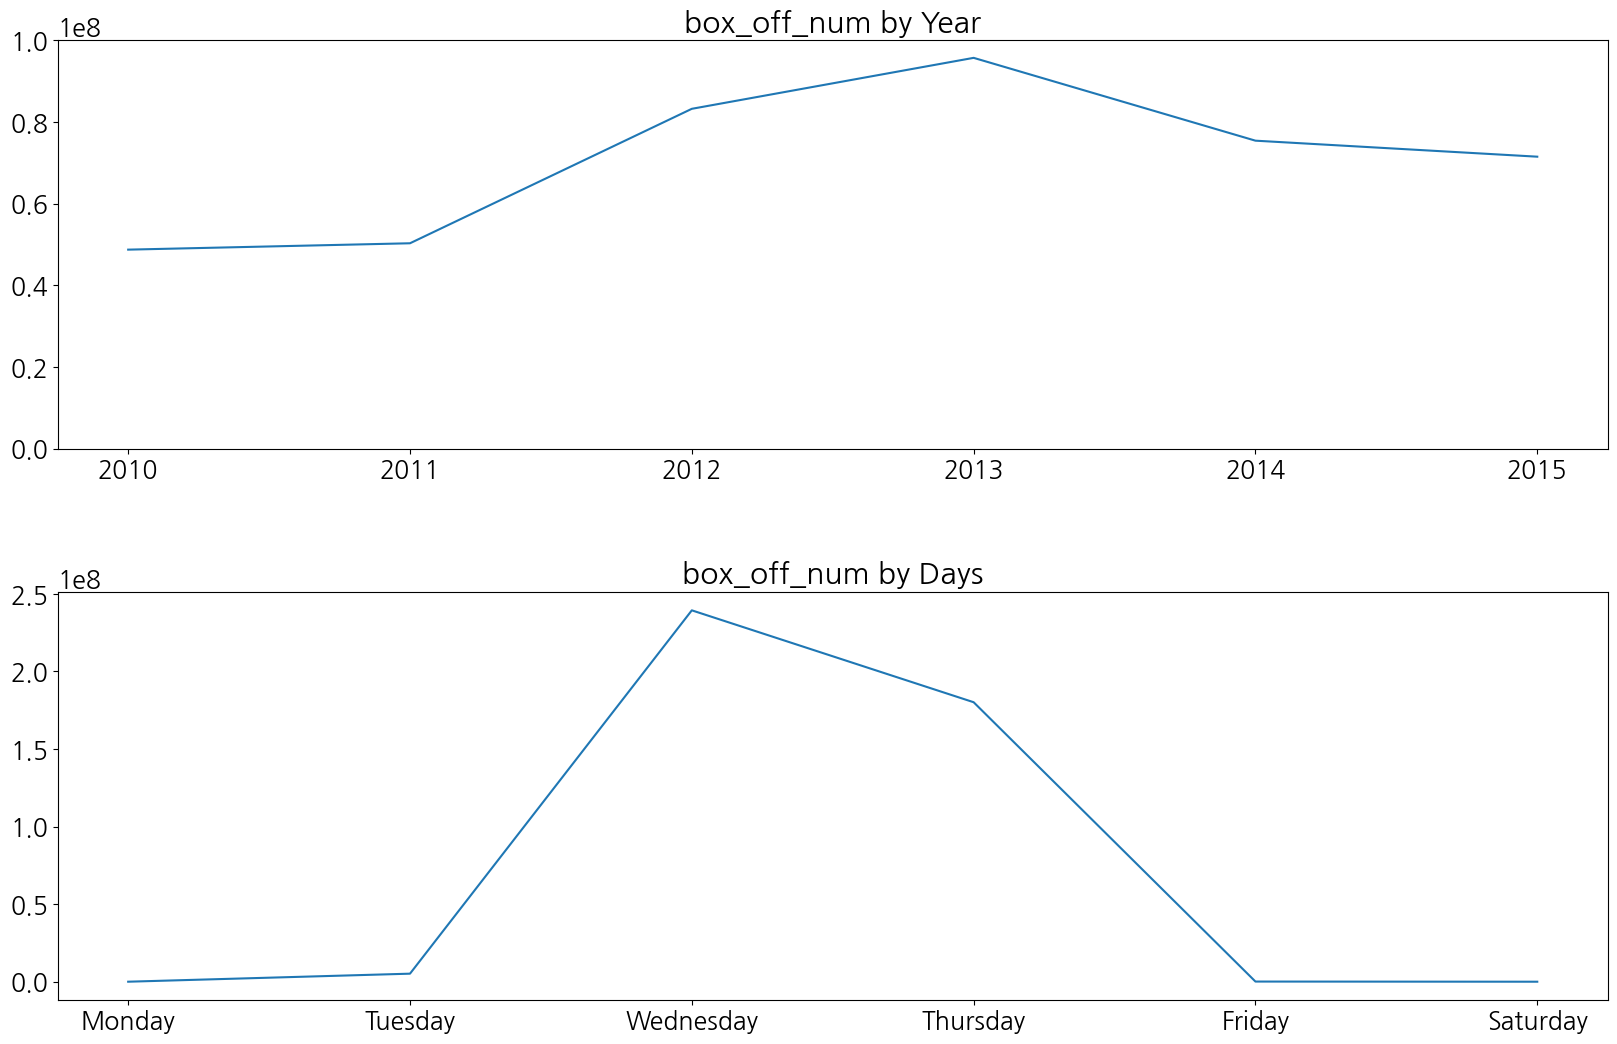

In [ ]:
# year, day 시각화
fig, ax = plt.subplots(2, 1, figsize=(20, 12))

ax[0].plot(df_year['year'], df_year['box_off_num'])
ax[0].set_title('box_off_num by Year')
ax[0].set_ylim(0,100000000)

ax[1].plot(df_day['day'], df_day['box_off_num'])
ax[1].set_title('box_off_num by Days')

plt.subplots_adjust(left=0.125, bottom=0.1, right=0.9, top=0.9, wspace=0.2, hspace=0.35)

plt.show()

 - 2013년에 정점을 찍고 2014년부터 감소하는 추세이다.
 - 수~목요일에 영화가 개봉하므로 가장 관객 수가 많다.

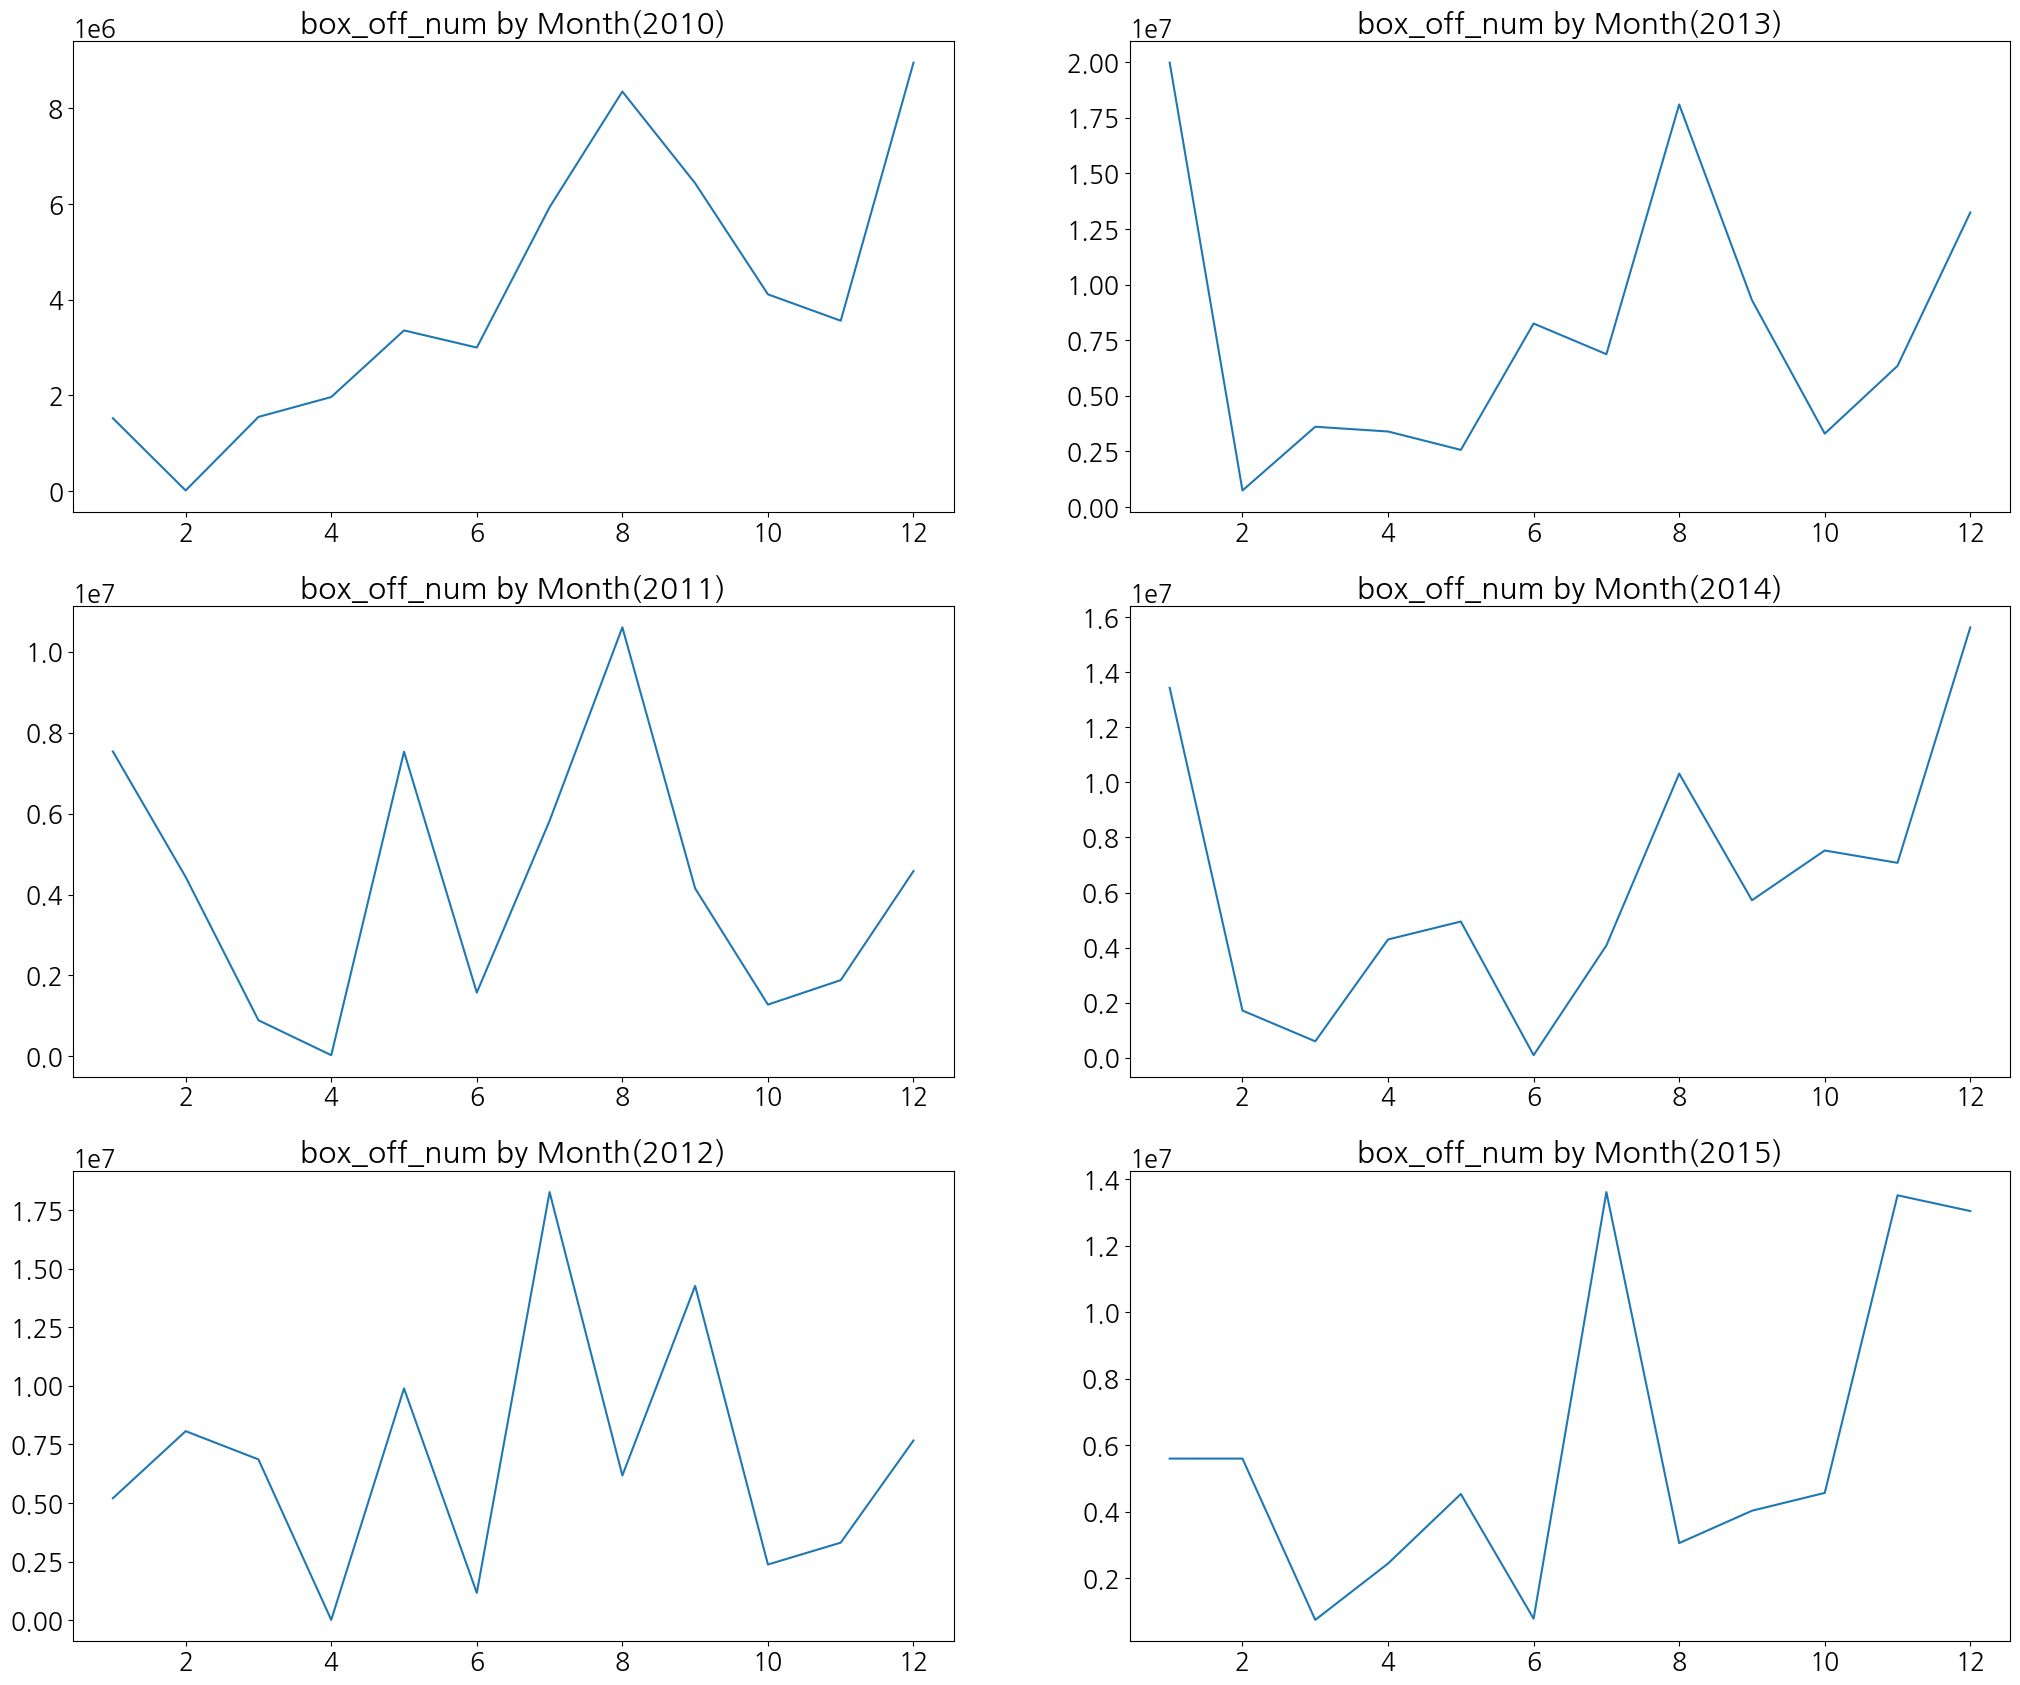

In [ ]:
# yearmonth 시각화
fig, ax = plt.subplots(3, 2, figsize=(25, 20))

ax[0,0].plot(df_yearmonth[df_yearmonth['year'] == 2010]['month'], df_yearmonth[df_yearmonth['year'] == 2010]['box_off_num'])
ax[0,0].set_title('box_off_num by Month(2010)')

ax[1,0].plot(df_yearmonth[df_yearmonth['year'] == 2011]['month'], df_yearmonth[df_yearmonth['year'] == 2011]['box_off_num'])
ax[1,0].set_title('box_off_num by Month(2011)')

ax[2,0].plot(df_yearmonth[df_yearmonth['year'] == 2012]['month'], df_yearmonth[df_yearmonth['year'] == 2012]['box_off_num'])
ax[2,0].set_title('box_off_num by Month(2012)')

ax[0,1].plot(df_yearmonth[df_yearmonth['year'] == 2013]['month'], df_yearmonth[df_yearmonth['year'] == 2013]['box_off_num'])
ax[0,1].set_title('box_off_num by Month(2013)')

ax[1,1].plot(df_yearmonth[df_yearmonth['year'] == 2014]['month'], df_yearmonth[df_yearmonth['year'] == 2014]['box_off_num'])
ax[1,1].set_title('box_off_num by Month(2014)')

ax[2,1].plot(df_yearmonth[df_yearmonth['year'] == 2015]['month'], df_yearmonth[df_yearmonth['year'] == 2015]['box_off_num'])
ax[2,1].set_title('box_off_num by Month(2015)')

plt.subplots_adjust(left=0.125, bottom=0.1, right=0.9, top=0.9, wspace=0.2, hspace=0.2)

plt.show()

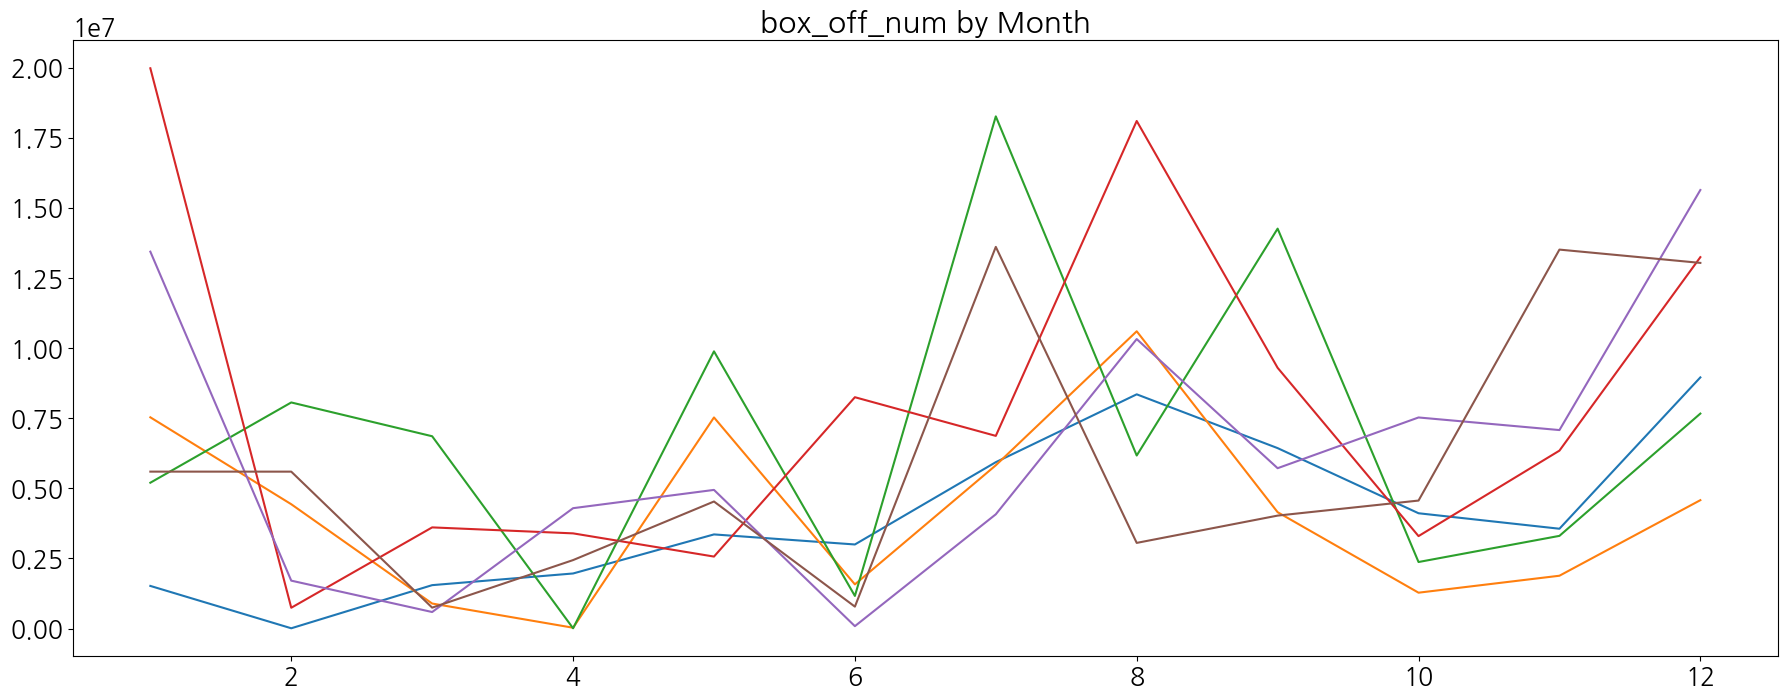

In [ ]:
fig, ax = plt.subplots(1, 1, figsize=(22, 8))

for i in range(2010, 2016):
    plt.plot(df_yearmonth[df_yearmonth['year'] == i]['month'], df_yearmonth[df_yearmonth['year'] == i]['box_off_num'])

plt.title('box_off_num by Month')

plt.show()

- 12-1월, 7-8월에 높은 것으로 나타난다

In [ ]:
# 일단 year, month 칼럼 추가해 주고 기존에 있는 release_time은 삭제한다.
# year 컬럼 추가
df_train['year'] = pd.to_datetime(df_train['release_time']).dt.year
df_test['year'] = pd.to_datetime(df_test['release_time']).dt.year

In [ ]:
# month 컬럼 추가
df_train['month'] = pd.to_datetime(df_train['release_time']).dt.month
df_test['month'] = pd.to_datetime(df_test['release_time']).dt.month

In [ ]:
# drop
df_train = df_train.drop('release_time', axis=1)
df_test = df_test.drop('release_time', axis=1)

# time

In [ ]:
df_train.head()

,distributor,genre,time,screening_rat,director,dir_prev_bfnum,dir_prev_num,num_staff,num_actor,box_off_num,year,month
0,롯데엔터테인먼트,액션,96,청소년 관람불가,조병옥,NaN,0,91,2,23398,2012,11
1,(주)쇼박스,느와르,130,청소년 관람불가,우민호,1161602.50,2,387,3,7072501,2015,11
2,(주)쇼박스,액션,123,15세 관람가,장철수,220775.25,4,343,4,6959083,2013,6
3,(주)NEW,코미디,101,전체 관람가,구자홍,23894.00,2,20,6,217866,2012,7
4,기타,코미디,108,15세 관람가,신근호,1.00,1,251,2,483387,2010,11


In [ ]:
df_train_time = df_train[['time','box_off_num']].sort_values('time').reset_index(drop=True)
df_train_time

,time,box_off_num
0,45,2919
1,60,328
2,61,71
3,61,188
4,62,152
...,...,...
595,153,1744585
596,156,2260512
597,163,3350311
598,166,4398


In [ ]:
df_train_time.describe()

,time,box_off_num
count,600.000000,6.000000e+02
mean,100.863333,7.081818e+05
std,18.097528,1.828006e+06
min,45.000000,1.000000e+00
25%,89.000000,1.297250e+03
50%,100.000000,1.259100e+04
75%,114.000000,4.798868e+05
max,180.000000,1.426277e+07


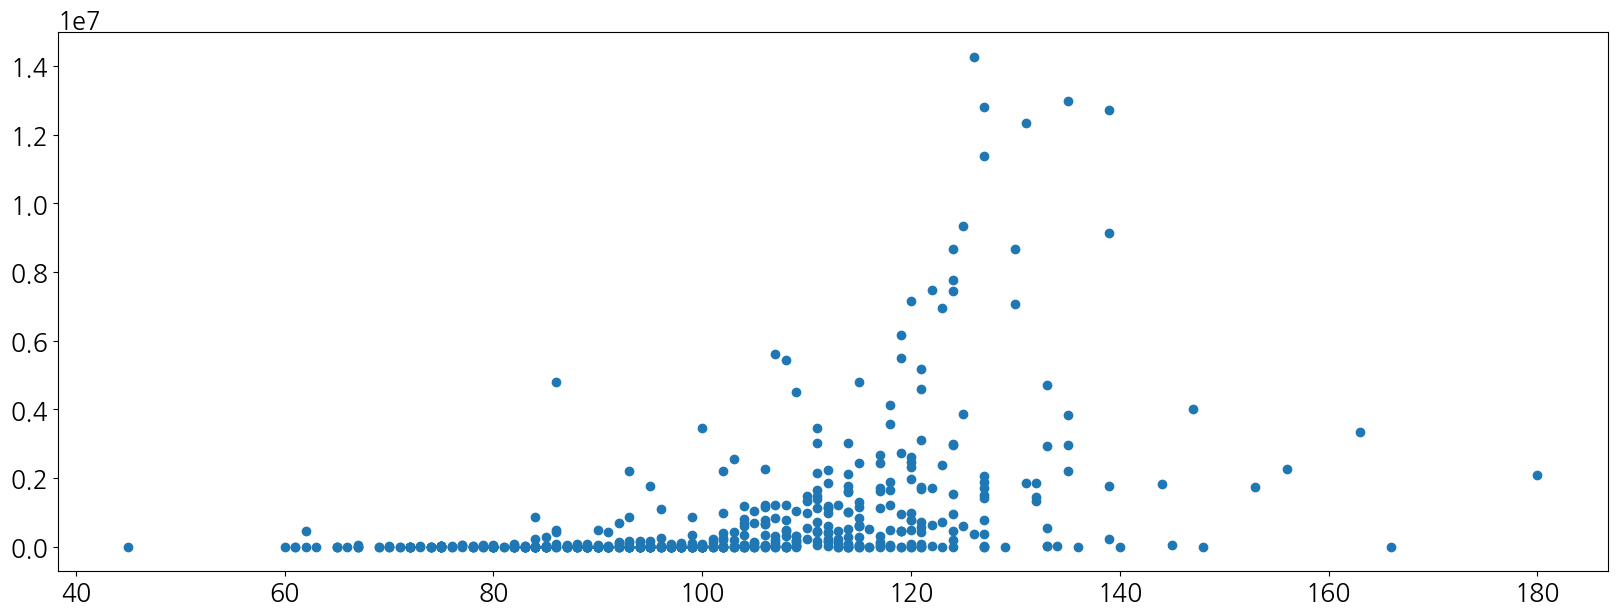

In [ ]:
fig, ax = plt.subplots(1, 1, figsize=(20, 7))

plt.scatter(df_train_time['time'], df_train_time['box_off_num'])

plt.show()

- 120~140분 사이의 영화가 많은 관객수



In [ ]:
# 100분 이하인 것들만 확인
df_train_time[df_train_time['time'] < 100]

,time,box_off_num
0,45,2919
1,60,328
2,61,71
3,61,188
4,62,152
...,...,...
293,99,600
294,99,542
295,99,13190
296,99,339


# screening_rat


*   상영등급



In [ ]:
pd.pivot_table(df_train[['screening_rat','box_off_num']], index=['screening_rat'], aggfunc=['count','sum'])

,count,sum
,box_off_num,box_off_num
screening_rat,,
12세 관람가,102,86188052
15세 관람가,202,251998766
전체 관람가,92,12429242
청소년 관람불가,204,74292991


In [ ]:
  # 각 관람가 연령별 장르별 갯수
df_train.groupby('screening_rat')['genre'].value_counts()

screening_rat  genre 
12세 관람가        드라마       50
               다큐멘터리     23
               멜로/로맨스    10
               코미디       10
               SF         3
               애니메이션      3
               공포         1
               뮤지컬        1
               액션         1
15세 관람가        드라마       76
               코미디       28
               멜로/로맨스    21
               공포        19
               다큐멘터리     17
               액션        16
               느와르        9
               미스터리       9
               SF         6
               애니메이션      1
전체 관람가         다큐멘터리     52
               드라마       17
               애니메이션     14
               뮤지컬        4
               코미디        3
               SF         1
               멜로/로맨스     1
청소년 관람불가       드라마       78
               멜로/로맨스    46
               공포        22
               느와르       18
               코미디       12
               액션        11
               미스터리       8
               SF         3
               애니메이션      

# director, dir_prev_bfnum, dir_prev_num

- director: 감독 이름
- dir_prev_bfnum: 해당 감독이 이 영화를 만들기 전 제작에 참여한 영화에서의 평균 관객수 (단 관객수가 알려지지 않은 영화 제외)
- dir_prev_num: 해당 감독이 이 영화를 만들기 전 제작에 참여한 영화의 개수 (단 관객수가 알려지지 않은 영화 제외)

In [ ]:
# 결측률이 50% 이상으로 drop 결정
print('dir_prev_bfnum의 결측률:', df_train['dir_prev_bfnum'].isnull().sum() / len(df_train['dir_prev_bfnum']))


dir_prev_bfnum의 결측률: 0.55


In [ ]:
df_train[(df_train['dir_prev_bfnum'].isnull()) & (df_train['dir_prev_num'] == 0)]


,distributor,genre,time,screening_rat,director,dir_prev_bfnum,dir_prev_num,num_staff,num_actor,box_off_num,year,month
0,롯데엔터테인먼트,액션,96,청소년 관람불가,조병옥,NaN,0,91,2,23398,2012,11
6,기타,다큐멘터리,104,전체 관람가,이창재,NaN,0,32,5,53526,2013,5
8,기타,뮤지컬,129,전체 관람가,정성복,NaN,0,3,5,4778,2014,9
9,기타,드라마,94,15세 관람가,변성현,NaN,0,138,3,868,2012,3
10,기타,멜로/로맨스,89,청소년 관람불가,조조 히데오,NaN,0,0,4,745,2015,7
...,...,...,...,...,...,...,...,...,...,...,...,...
593,기타,미스터리,97,청소년 관람불가,최위안,NaN,0,5,3,1132,2013,9
594,(주)마운틴픽쳐스,코미디,94,청소년 관람불가,노진수,NaN,0,37,5,1958,2014,3
597,(주)마운틴픽쳐스,공포,99,청소년 관람불가,김대현,NaN,0,123,4,2475,2010,9
598,CJ 엔터테인먼트,느와르,102,15세 관람가,백운학,NaN,0,431,4,2192525,2015,5


- null값인 데이터의 dir_prev_num, 즉 이전에 참여한 영화의 갯수가 0인 것을 알 수 있다.
- 일반적으로 측정되거나 조사된 값에서 55%가 비어 있다면 유의미한 데이터라고 보기는 어려울 수 있다.
- 하지만, 해당 변수는 감독이 영화를 만들기 전 제작에 참여한 영화에서의 평균 관객수로, 이전에 영화 제작에 참여하지 않은 신인 감독의 경우 0이 나오게 될 수도 있다.
- 적절히 구간을 나누어 변수로 만들어보자.

<Axes: title={'center': 'Pearson Correalation of Features'}>

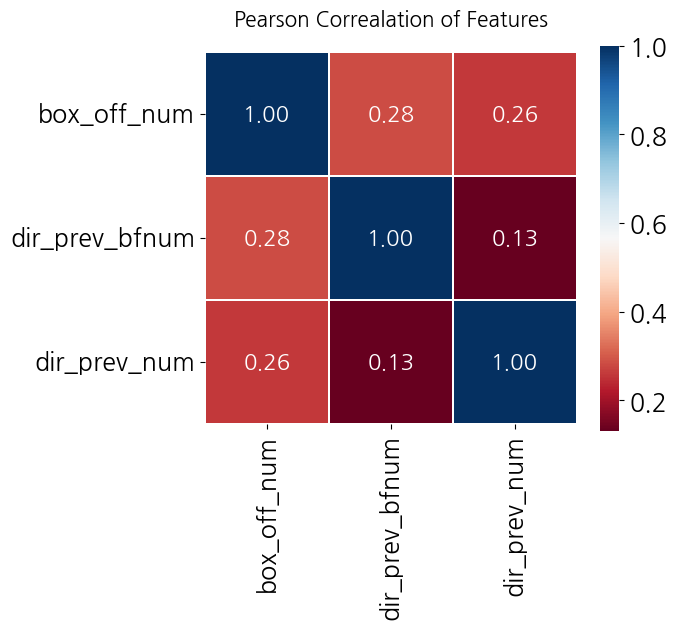

In [ ]:
heatmap_data = df_train[['box_off_num','dir_prev_bfnum','dir_prev_num']]
colormap = plt.cm.RdBu
plt.figure(figsize=(6, 5))
plt.title('Pearson Correalation of Features', y=1.05, size=15)
sns.heatmap(heatmap_data.astype(float).corr(), linewidths=0.1, vmax=1.0
            , square=True, cmap=colormap, linecolor='white', annot=True, annot_kws={'size': 16}, fmt='.2f')


In [ ]:
# 한 명의 감독이 많으면 7개의 영화에 참여했다.
df_train['director'].value_counts().sort_values()

김재환         1
최경석         1
이해준         1
하마구치 류스케    1
오기환         1
           ..
노진수         4
우민호         4
신재호         4
장률          4
홍상수         7
Name: director, Length: 472, dtype: int64

In [ ]:
df_train_dir = df_train.groupby('director', as_index=False)['dir_prev_bfnum','dir_prev_num'] \
                .sum().sort_values(by='dir_prev_bfnum', ascending=False).reset_index(drop=True)
df_train_dir

<ipython-input-138-5a28ebf5e664>:1: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  df_train_dir = df_train.groupby('director', as_index=False)['dir_prev_bfnum','dir_prev_num'] \


,director,dir_prev_bfnum,dir_prev_num
0,고구마,17615314.0,1
1,강형철,16061870.5,3
2,김민석,8801639.0,2
3,심형래,7855474.0,1
4,김상진,7815569.0,8
...,...,...,...
467,백승화,0.0,0
468,백승기,0.0,0
469,백동훈,0.0,0
470,배창호,0.0,0


In [ ]:
df_train_dir.describe()

,dir_prev_bfnum,dir_prev_num
count,4.720000e+02,472.000000
mean,6.008889e+05,1.114407
std,1.669276e+06,1.658679
min,0.000000e+00,0.000000
25%,0.000000e+00,0.000000
50%,0.000000e+00,0.000000
75%,4.692358e+05,2.000000
max,1.761531e+07,9.000000


In [ ]:
df_train_dir[df_train_dir['dir_prev_bfnum'] > 0]

,director,dir_prev_bfnum,dir_prev_num
0,고구마,17615314.0,1
1,강형철,16061870.5,3
2,김민석,8801639.0,2
3,심형래,7855474.0,1
4,김상진,7815569.0,8
...,...,...,...
217,배형준,19.0,2
218,주경중,17.0,1
219,정용주,8.0,1
220,이성은,7.0,1


In [ ]:
df_train_dir[df_train_dir['dir_prev_bfnum'] > 0].describe()

,dir_prev_bfnum,dir_prev_num
count,2.220000e+02,222.000000
mean,1.277566e+06,2.369369
std,2.251710e+06,1.696032
min,1.000000e+00,1.000000
25%,2.085254e+04,1.000000
50%,5.118668e+05,2.000000
75%,1.523155e+06,3.000000
max,1.761531e+07,9.000000


In [ ]:
# 함수 구현
def director_set(x):
    if x == 0:
        return 1 # 신인
    elif x < 511867:
        return 2 # 아마추어
    elif x < 1523155:
        return 3 # 프로
    else:
        return 4 # 거장

In [ ]:
df_train_dir['director_en'] = df_train_dir['dir_prev_bfnum'].apply(director_set)
df_train_dir

,director,dir_prev_bfnum,dir_prev_num,director_en
0,고구마,17615314.0,1,4
1,강형철,16061870.5,3,4
2,김민석,8801639.0,2,4
3,심형래,7855474.0,1,4
4,김상진,7815569.0,8,4
...,...,...,...,...
467,백승화,0.0,0,1
468,백승기,0.0,0,1
469,백동훈,0.0,0,1
470,배창호,0.0,0,1


- 이렇게 구분하는 경우 train 데이터에서는 잘 구분될 수 있지만 새로운 데이터에서는 의미가 없을 수 있다.
- 거장 감독이지만 train set에 없다면 새로운 데이터를 검증하기 어려우며, 신인 감독인 경우에도 마찬가지일 수 있다.

In [ ]:
# director drop

df_train = df_train.drop('director', axis=1)
df_test = df_test.drop('director', axis=1)

In [ ]:
# dir_prev_bfnum drop

df_train = df_train.drop('dir_prev_bfnum', axis=1)
df_test = df_test.drop('dir_prev_bfnum', axis=1)

In [ ]:
# dir_prev_num 대기

df_train = df_train.drop('dir_prev_num', axis=1)
df_test = df_test.drop('dir_prev_num', axis=1)

# num_staff

- 스태프 수
- 스태프 수가 많을수록 제작비가 많이 들어갔다는 의미이니, 관객을 많이 모을 수 있을까?
- 스태프 수에 따라 소형, 중형, 대형으로 나누어 보았다.

In [ ]:
df_train_staff = df_train[['num_staff','box_off_num']]
df_train_staff

,num_staff,box_off_num
0,91,23398
1,387,7072501
2,343,6959083
3,20,217866
4,251,483387
...,...,...
595,510,1475091
596,286,1716438
597,123,2475
598,431,2192525


In [ ]:
df_train_staff.describe()

,num_staff,box_off_num
count,600.000000,6.000000e+02
mean,151.118333,7.081818e+05
std,165.654671,1.828006e+06
min,0.000000,1.000000e+00
25%,17.000000,1.297250e+03
50%,82.500000,1.259100e+04
75%,264.000000,4.798868e+05
max,869.000000,1.426277e+07


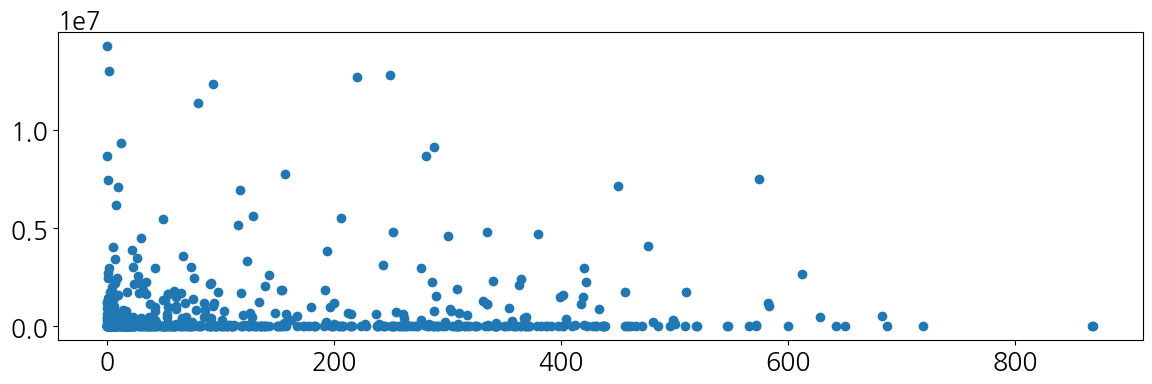

In [ ]:
fig, ax = plt.subplots(1, 1, figsize=(14, 4))

plt.scatter(df_train_staff['num_staff'], df_train_time['box_off_num'])

plt.show()

# num_actor


*   주연 배우 수



In [ ]:
df_train[['num_actor','box_off_num']]

,num_actor,box_off_num
0,2,23398
1,3,7072501
2,4,6959083
3,6,217866
4,2,483387
...,...,...
595,7,1475091
596,6,1716438
597,4,2475
598,4,2192525


In [ ]:
df_train['num_actor'].describe()


count    600.000000
mean       3.706667
std        2.446889
min        0.000000
25%        2.000000
50%        3.000000
75%        4.000000
max       25.000000
Name: num_actor, dtype: float64

- 주연 배우의 수는 대부분 2명 수준

# box_off_num(Target)

In [ ]:
df_train['box_off_num'] = np.log1p(df_train['box_off_num'])

# 학습 데이터 준비

In [ ]:
df_train.shape, df_test.shape

((600, 9), (243, 8))

# 원 핫 인코딩

In [ ]:
df_train = pd.get_dummies(df_train)
df_test = pd.get_dummies(df_test)

In [ ]:
df_train.shape, df_test.shape

((600, 28), (243, 27))

# Modeling - Prediction - Submission

Modeling

In [ ]:
X = df_train.drop(['box_off_num'],axis= 1)

In [ ]:
y = df_train['box_off_num']

In [ ]:
# 최적값을 구하고 싶은 파라미터를 정리 
from sklearn.model_selection import RandomizedSearchCV
from xgboost import XGBRegressor

dists = {
    'xgboostregressor__n_estimators' : [230,240,250,260,270,280],
    'xgboostregressor__max_depth' : [5,6,7],
    'xgboostregressor__gamma' : [0, 1, 2],
    'xgboostregressor__eta' : [0.01, 0.02, 0.03, 0.04, 0.05],
    'xgboostregressor__subsample' : [0.7,0.75, 0.8],
    'xgboostregressor__mean_child_weight' : [0.9, 1, 1.1],
    'xgboostregressor__importance_type' : ['gain'],
    'xgboostregressor__reg_lambda' : [0.9, 1, 1.1],
}

# RandomizedSearchCV 작성
regressor1 = RandomizedSearchCV(
    XGBRegressor(random_state=100),
    param_distributions=dists, # 파라미터 입력
    n_iter = 50,   # random search 탐색 횟수
    cv = 5,        # cv 검증을 위한 분할 검증 횟수
    scoring='neg_mean_squared_error',  # 오차 평가방법
    verbose=1,     # 진행상황
    random_state = 100
  )

regressor1.fit(X, y)

Fitting 5 folds for each of 50 candidates, totalling 250 fits
[05:20:39] WARNING: ../src/learner.cc:767: 
Parameters: { "xgboostregressor__eta", "xgboostregressor__gamma", "xgboostregressor__importance_type", "xgboostregressor__max_depth", "xgboostregressor__mean_child_weight", "xgboostregressor__n_estimators", "xgboostregressor__reg_lambda", "xgboostregressor__subsample" } are not used.

[05:20:39] WARNING: ../src/learner.cc:767: 
Parameters: { "xgboostregressor__eta", "xgboostregressor__gamma", "xgboostregressor__importance_type", "xgboostregressor__max_depth", "xgboostregressor__mean_child_weight", "xgboostregressor__n_estimators", "xgboostregressor__reg_lambda", "xgboostregressor__subsample" } are not used.

[05:20:40] WARNING: ../src/learner.cc:767: 
Parameters: { "xgboostregressor__eta", "xgboostregressor__gamma", "xgboostregressor__importance_type", "xgboostregressor__max_depth", "xgboostregressor__mean_child_weight", "xgboostregressor__n_estimators", "xgboostregressor__reg_lamb

RandomizedSearchCV(cv=5,
                   estimator=XGBRegressor(base_score=None, booster=None,
                                          callbacks=None,
                                          colsample_bylevel=None,
                                          colsample_bynode=None,
                                          colsample_bytree=None,
                                          early_stopping_rounds=None,
                                          enable_categorical=False,
                                          eval_metric=None, feature_types=None,
                                          gamma=None, gpu_id=None,
                                          grow_policy=None,
                                          importance_type=None,
                                          interaction_constraints=None,
                                          learning_rate=...
                                        'xgboostregressor__gamma': [0, 1, 2],
                                        'xgboostregressor__importance_type': ['gain'],
                                        'xgboostregressor__max_depth': [5, 6,
                                                                        7],
                                        'xgboostregressor__mean_child_weight': [0.9,
                                                                                1,
                                                                                1.1],
                                        'xgboostregressor__n_estimators': [230,
                                                                           240,
                                                                           250,
                                                                           260,
                                                                           270,
                                                                           280],
                                        'xgboostregressor__reg_lambda': [0.9, 1,
                                                                         1.1],
                                        'xgboostregressor__subsample': [0.7,
                                                                        0.75,
                                                                        0.8]},
                   random_state=100, scoring='neg_mean_squared_error',
                   verbose=1)

In [ ]:
# best_model = regressor1.best_estimator_
best_params = regressor1.best_params_

# print('best params: ', best_params)
# print('train score: {:.3f}'.format(np.sqrt(-regressor1.best_score_)))

# y_pred = best_model.predict(X)
# rmse_test = mean_squared_error(y, y_pred)**0.5
# print('test set score: ', (rmse_test))
best_params

{'xgboostregressor__subsample': 0.7,
 'xgboostregressor__reg_lambda': 1.1,
 'xgboostregressor__n_estimators': 250,
 'xgboostregressor__mean_child_weight': 1.1,
 'xgboostregressor__max_depth': 6,
 'xgboostregressor__importance_type': 'gain',
 'xgboostregressor__gamma': 2,
 'xgboostregressor__eta': 0.04}

In [ ]:
rgr = XGBRegressor(
            n_estimators=250,
            max_depth=6,
            gamma = 2,
            eta = 0.07,
            subsample = 0.6,
            min_child_weight = 1,
            reg_lambda = 1,
            random_state=100
        ).fit(X,y)

In [ ]:
from sklearn.model_selection import cross_val_score

scores = cross_val_score(rgr, X, y, scoring='neg_mean_squared_error', cv=5)
rmse = np.sqrt(-scores)
print('RMSE:', np.round(rmse, 3))
print('RMSE average: %0.3f' % (rmse.mean()))
print(rgr.score(X, y))

RMSE: [1.903 1.924 2.03  1.81  1.9  ]
RMSE average: 1.913
0.9655154913817299


In [ ]:
# 변수 중요도
for i, feature in enumerate(df_test.columns):
    print(f'{feature} : {rgr.feature_importances_[i]}')

time : 0.04094791039824486
num_staff : 0.14437222480773926
num_actor : 0.025790581479668617
year : 0.030795559287071228
month : 0.024133270606398582
distributor_(주)NEW : 0.047671012580394745
distributor_(주)마운틴픽쳐스 : 0.05024074763059616
distributor_(주)쇼박스 : 0.03269911929965019
distributor_CJ 엔터테인먼트 : 0.02853349968791008
distributor_기타 : 0.08563192188739777
distributor_롯데엔터테인먼트 : 0.02381751500070095
genre_SF : 0.02103564515709877
genre_공포 : 0.02334539033472538
genre_느와르 : 0.023418009281158447
genre_다큐멘터리 : 0.029385428875684738
genre_드라마 : 0.04175044968724251
genre_멜로/로맨스 : 0.035679616034030914
genre_뮤지컬 : 0.013979008421301842
genre_미스터리 : 0.03189150616526604
genre_서스펜스 : 0.0
genre_애니메이션 : 0.07749086618423462
genre_액션 : 0.01792469434440136
genre_코미디 : 0.028670286759734154
screening_rat_12세 관람가 : 0.02224464900791645
screening_rat_15세 관람가 : 0.022996649146080017
screening_rat_전체 관람가 : 0.0407523550093174
screening_rat_청소년 관람불가 : 0.034802090376615524


<Axes: title={'center': 'Top features'}>

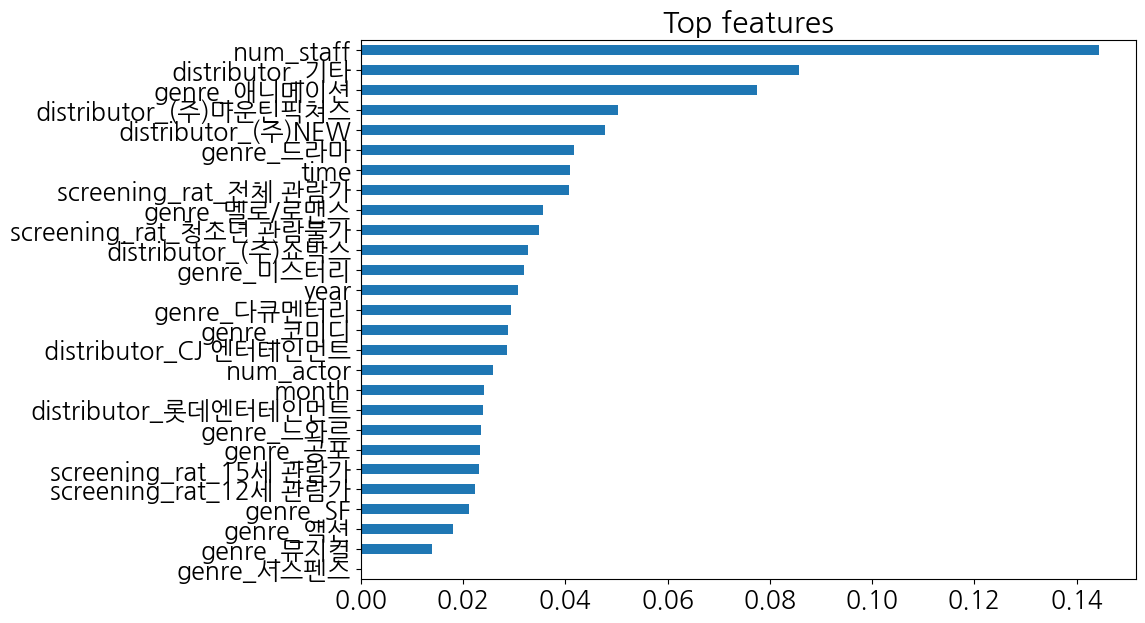

In [ ]:
importances = pd.Series(rgr.feature_importances_, X.columns)

n = 5
plt.figure(figsize=(10, 7))
plt.title(f'Top features')
importances.sort_values().plot.barh()

# Prediction

In [ ]:
prediction = rgr.predict(df_test) ### xgb or rgr

# Submission

In [ ]:
submission = pd.read_csv('/content/drive/MyDrive/moviedata/submission.csv')
submission.head(2)

,title,box_off_num
0,용서는 없다,0
1,아빠가 여자를 좋아해,0


In [ ]:
submission['box_off_num'] = prediction
submission.head(2)

,title,box_off_num
0,용서는 없다,12.718703
1,아빠가 여자를 좋아해,13.158280


In [ ]:
import datetime
submission_title = 'v6'+'_movie_submission_'+datetime.datetime.now().strftime("%y%m%d_%H%M")
submission.to_csv(submission_title+'.csv',index = False)
'-----' + submission_title + ' saved -----'

'-----v6_movie_submission_230604_0521 saved -----'